In [2]:
try:
    if is_init:
        pass
except:
    %pwd
    %cd ..
    %pwd
    is_init = True

/home/spencersong/metamaterials_ai/src


In [3]:
from pathlib import Path
from src.utils import FileUtils
from config import Config
from utils import rmse
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from src.predictor import Predictor
data_folder = '../local_data'
work_folder = '../local_work'
configs_folder = '../configs'

In [4]:
#CHANGEME: model paths! 
I_INC_CKPT_PATH = '../local_work/saved_best/I-1-res-ann-inconel.ckpt' #../data/models/model.ckpt"
I_SS_CKPT_PATH = '../local_work/saved_best/I-1-res-ann-stainless.ckpt' #../data/models/model.ckpt"
D_INC_CKPT_PATH = '../local_work/saved_best/D-1-res-ann-inconel-2022-07-15_23-44.ckpt' #../data/models/model.ckpt"
D_SS_CKPT_PATH = '../local_work/saved_best/D-1-res-ann-stainless.ckpt' #../data/models/model.ckpt"

In [5]:
# read_file
# read_file = pd.read_csv('../src/notebooks/sample_input.csv')
# desired_emiss = interpolate(read_file) #torch.from_numpy(np.array(torch.randn(1, 800) * 3))

include_inconel = False #Change ME
include_stainless = True #Change ME
round_laser_params = True #Change Me

def get_data( filepath, type):
    stain_data = torch.load(
                    Path(filepath))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
    wave_data = stain_data["interpolated_wavelength"]
    emiss_data = stain_data["interpolated_emissivity"]
    laser_params = stain_data["laser_params"]
    uids = stain_data["uids"]
    if type == 'test':
        wave_test = wave_data[round(len(wave_data) * .9):]  
        emiss_test = emiss_data[round(len(wave_data) * .9):]
        laser_params = laser_params[round(len(wave_data) * .9):]
        uids = uids[round(len(wave_data) * .9):]
    elif type == 'trainval':
        wave_test = wave_data[:round(len(wave_data) * .9)]  
        emiss_test = emiss_data[:round(len(wave_data) * .9)]
        laser_params = laser_params[:round(len(wave_data) * .9)]
        uids = uids[:round(len(wave_data) * .9)]
    else: 
        wave_test = wave_data
        emiss_test = emiss_data
        laser_params = laser_params
    
    return wave_test, emiss_test, laser_params, uids

inc_params = torch.load(
                Path(f"{data_folder}/inconel-onehot.pt"))["laser_params"]

steel_wave_test, steel_emiss_test, steel_laser_params_test, steel_uids_test = get_data(f"{data_folder}/steel-onehot.pt", "test")
steel_wave, steel_emiss, steel_laser_params, steel_uids = get_data(f"{data_folder}/steel-onehot.pt", "full")
inconel_wave, inconel_emiss, inconel_laser_params, inconel_uids = get_data(f"{data_folder}/inconel-onehot.pt", "full")
inconel_wave_test, inconel_emiss_test, inconel_laser_params_test, inconel_uids_test = get_data(f"{data_folder}/inconel-onehot.pt", "test")

# max_speed, max_spacing = steel_laser_params.max(0)[0][0].item(), steel_laser_params.max(0)[0][1].item()
# min_speed, min_spacing = steel_laser_params.min(0)[0][0].item(), steel_laser_params.min(0)[0][1].item()

In [6]:

# for emiss in emiss_test:
predictor = Predictor(I_INC_CKPT_PATH, I_SS_CKPT_PATH,  D_INC_CKPT_PATH,  D_SS_CKPT_PATH, round_laser_params = True)
#run inverse models
y_hat_ss = predictor.run_model(steel_emiss_test, "steel", "inverse")
y_hat_inc = predictor.run_model(inconel_emiss_test, "inconel", "inverse")
# decode predictions from inverse model
y_hat_ss_norm = predictor.denormalize_and_decode(y_hat_ss, "steel", False)
y_hat_inc_norm = predictor.denormalize_and_decode(y_hat_inc, "inconel", False)

ss_not_in_data, ss_same_params, ss_y_hat_in_data, ss_y_test = predictor.find_in_data(y_hat_ss_norm, 'steel')
inc_not_in_data, inc_same_params, inc_y_hat_in_data, inc_y_test = predictor.find_in_data(y_hat_inc_norm, 'inconel')

#run direct models on inverse output
y_hat_ss = predictor.run_model(y_hat_ss, "steel", "direct")
y_hat_inc = predictor.run_model(y_hat_inc, "inconel", "direct")

#run ensemble on

/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:217: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['direct_model.model.0.weight', 'direct_model.model.0.bias', 'direct_model.model.2.layers.0.block.0.weight', 'direct_model.model.2.layers.0.block.0.bias', 'direct_model.model.2.layers.1.block.0.weight', 'direct_model.model.2.layers.1.block.0.bias', 'direct_model.model.2.layers.2.block.0.weight', 'direct_model.model.2.layers.2.block.0.bias', 'direct_model.model.2.layers.3.block.0.weight', 'direct_model.model.2.layers.3.block.0.bias', 'direct_model.model.2.layers.4.block.0.weight', 'direct_model.model.2.

In [7]:
y_hat = y_hat_ss_norm

print(len(ss_not_in_data))
print(len(ss_same_params))
print(len(ss_y_test["laser_params"]))

567
5
2466


In [8]:
# RMSE SCORES FOR ROUNDED PREDICTIONS FOUND IN DATA
mean_rmse, stdev_rmse = predictor.rmse_metrics(ss_y_hat_in_data["emissivity"], ss_y_test["emissivity"], decimals = 5)
print(f'Mean RMSE: {mean_rmse}, SD: {stdev_rmse}')


Mean RMSE: 0.026040000841021538, SD: 0.018459999933838844


In [9]:
#Clean up parameters out of data and 'send_to_lab'  #DO NOT TOUCH
send_to_lab, size_unique, size_total = predictor.clean_and_send_to_lab(ss_not_in_data)
print(f'Total # of Preds: {size_total}, Unique # of Preds: {size_unique}')

Total # of Preds: 567, Unique # of Preds: 96


## SAD Metric Analysis

In [10]:
#compute SAD between parameters
y_hat_params, test_params, sad_values, rmses, y_hat_uids, test_uids = predictor.SAD(ss_y_hat_in_data, ss_y_test, "steel")


In [11]:
#create DF comparing laser parameters, SAD, and RMSE
columns = ['Pred UID', 'speed_pred', 'spacing_pred', 'power_pred', 'Test UID', 'speed_test', 'spacing_test', 'power_test', 'SAD', 'RMSE']
sad_df = pd.DataFrame(torch.cat((y_hat_uids, y_hat_params, test_uids, test_params, sad_values, rmses), dim = 1).numpy(), columns = columns)

In [12]:
sad_df[['SAD']].describe()

,SAD
count,2466.000000
mean,0.810526
std,0.422367
min,0.014493
25%,0.492259
50%,0.771386
75%,1.100530
max,2.160233


In [13]:
alt.Chart(sad_df).mark_circle(size=60).encode(
    x='RMSE',
    y='SAD',
    color='speed_pred'
).properties(title = 'RMSE vs SAD')


alt.Chart(...)

In [14]:
alt.Chart(sad_df).mark_circle(size=60).encode(
    x='RMSE',
    y='SAD',
    color='power_pred'
).properties(title = 'RMSE vs SAD')


alt.Chart(...)

In [15]:
alt.Chart(sad_df).mark_circle(size=60).encode(
    x='RMSE',
    y='SAD',
    color='spacing_pred'
).properties(title = 'RMSE vs SAD')


alt.Chart(...)

In [16]:
#look at subset of predictions
#sad_df[(sad_df['SAD'] > .77) & (sad_df['SAD'] < .79)]
sad_df[sad_df['RMSE'] > .14]

,Pred UID,speed_pred,spacing_pred,power_pred,Test UID,speed_test,spacing_test,power_test,SAD,RMSE
677,1307.0,20.0,23.0,0.6,32705.0,30.0,13.0,0.6,0.258395,0.171009
1314,1307.0,20.0,23.0,0.6,33634.0,270.0,3.0,1.1,1.350124,0.145591
1630,1307.0,20.0,23.0,0.6,34081.0,190.0,6.0,1.2,1.261011,0.167489
1775,31595.0,490.0,28.0,0.6,34292.0,670.0,30.0,0.8,0.509650,0.254674


In [17]:
comparison_UID = list(sad_df[sad_df['RMSE'] > .14][["Pred UID", "Test UID"]].itertuples(index = False, name = None))
comparison_UID

[(1307.0, 32705.0), (1307.0, 33634.0), (1307.0, 34081.0), (31595.0, 34292.0)]

In [18]:
len(steel_laser_params)

30380

In [19]:
len(steel_wave)#.astype(int)

30380

In [35]:
#calculate rmse
pred_rmse_vals = []
columns = ["wavelength", "emissivity", "prediction", "example_number", "laser_params"]
viz_coords = pd.DataFrame(columns = columns)
graph_num = 0
for i, k in comparison_UID:#len(emiss_test)):
    index_i = (steel_uids == i).nonzero()[0].item()
    index_k = (steel_uids == k).nonzero()[0].item()
    curr_rmse = rmse(steel_emiss[index_i], steel_emiss[index_k]).item()
    graph_title = f'RMSE: {round(curr_rmse, 4)},Pred Params:({steel_laser_params[index_i][0]},{steel_laser_params[index_i][1]},{steel_laser_params[index_i][2]}), Test Params:({steel_laser_params[index_k][0]},{steel_laser_params[index_k][1]},{steel_laser_params[index_k][2]})'
    for j in range(steel_wave.shape[1]):
        pd1 = pd.DataFrame([[steel_wave[index_i][j].item(), steel_emiss[index_i][j].item(), "pred", graph_num, graph_title]], columns = columns)
        pd2 = pd.DataFrame([[steel_wave[index_k][j].item(), steel_emiss[index_k][j].item(), "test", graph_num, graph_title]], columns = columns)
        viz_coords = pd.concat([viz_coords,pd1, pd2])
    graph_num += 1
stdev = np.std(pred_rmse_vals)
print(f'SD of RMSEs on test data: {stdev}')


SD of RMSEs on test data: nan


/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
viz_coords

,wavelength,emissivity,prediction,example_number,laser_params
0,2.500184,0.964549,pred,0,"RMSE: 0.171,Pred Params:(20.0,23.0,0.0), Test ..."
0,2.500184,0.958776,test,0,"RMSE: 0.171,Pred Params:(20.0,23.0,0.0), Test ..."
0,2.512008,0.964253,pred,0,"RMSE: 0.171,Pred Params:(20.0,23.0,0.0), Test ..."
0,2.512008,0.958127,test,0,"RMSE: 0.171,Pred Params:(20.0,23.0,0.0), Test ..."
0,2.523833,0.964131,pred,0,"RMSE: 0.171,Pred Params:(20.0,23.0,0.0), Test ..."
...,...,...,...,...,...
0,11.924233,0.089453,test,3,"RMSE: 0.2547,Pred Params:(490.0,28.0,0.0), Tes..."
0,11.936058,0.375023,pred,3,"RMSE: 0.2547,Pred Params:(490.0,28.0,0.0), Tes..."
0,11.936058,0.08939,test,3,"RMSE: 0.2547,Pred Params:(490.0,28.0,0.0), Tes..."
0,11.947882,0.374932,pred,3,"RMSE: 0.2547,Pred Params:(490.0,28.0,0.0), Tes..."


In [37]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(viz_coords).mark_line().encode(
    x='wavelength',
    y='emissivity',
    color='prediction'
).facet(facet = 'laser_params', title = 'Predictions vs. Test')#.encode(text = 'laser_params:N').

alt.FacetChart(...)

Text(0.5, 1.0, 'Normalized Difference between Parameters and Predicted Parameters')

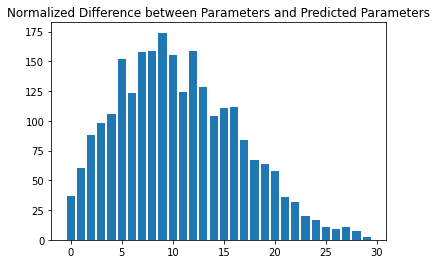

In [19]:
#Computer SAD between  parameters in data and test parameters
hist = torch.histc(torch.sum(sad_values, dim = 1), bins = 30)
plt.bar(range(30), hist)
plt.title("Normalized Difference between Parameters and Predicted Parameters")


VAL: tensor([7266])
YHAT: tensor([100.,  21.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[100.,  21.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([27063])
YHAT: tensor([90., 25.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
CHECK: tensor([[90., 25.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
VAL: tensor([1604])
YHAT: tensor([480.,  38.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[480.,  38.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([2392])
YHAT: tensor([300.,  42.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[300.,  42.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([], dtype=torch.int64)
YHAT: tensor([360.,  35.,   0.,   0.,   0.,   0.,   0.,  

In [ ]:
not_in_data = []
same_params_uids = []
pred_in_data = {"laser_params": [], "emissivity": [], "uids": []}
test_in_data = {"laser_params": [], "emissivity": [], "uids": []}

if substrate == 'steel':
        wave, emiss, laser_params, uids = get_data(SS_DATA_PATH, "trainval")
        wave_test, emiss_test, laser_params_test, uids_test = self.get_data(SS_DATA_PATH, "test")
else:
        wave, emiss, laser_params, uids = self.get_data(INC_DATA_PATH, "trainval")
        wave_test, emiss_test, laser_params_test, uids_test = self.get_data(INC_DATA_PATH, "test")

#[]#torch.tensor(type = "torch.float32")
for i in range(len(y_hat)):
        print(f'LEN INPUT: {len(y_hat)}')
        val = torch.all(laser_params == y_hat[i], axis=1).nonzero().flatten()
        if len(val) == 0:
                not_in_data.append(y_hat[i])
        else:
        #if the predicted parameters = the original parameters
                same_params = torch.all(torch.eq(y_hat[i], laser_params_test[i])).item()
                if same_params:
                        same_params_uids.append(uids[val])
                #if the predicted != original parameters, add to two separate dictionaries
                else:
                        pred_in_data["laser_params"].append(laser_params[val])
                        pred_in_data["emissivity"].append(emiss[val])
                        pred_in_data["uids"].append(uids[val])
                        test_in_data["laser_params"].append(laser_params_test[i])
                        test_in_data["emissivity"].append(emiss_test[i])
                        test_in_data["uids"].append(uids_test[i])
#list of tensors --> tensors
not_in_data = torch.stack(not_in_data)

In [9]:
print(len(not_in_data))
print(len(same_params_uids))
print(len(y_hat_in_data))

567
5
2471


In [21]:
torch.all(all_params == not_in_data, axis=1).nonzero().flatten()

tensor([[360.,  35.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])

In [17]:
to_minok = predictor.clean_to_minok(not_in_data)
torch.unique(to_minok, dim = 1)
#len(set(not_in_data))

tensor([[  0.7000,  35.0000, 360.0000],
        [  0.7000,  37.0000, 350.0000],
        [  0.7000,  40.0000, 380.0000],
        ...,
        [  0.7000,  36.0000, 310.0000],
        [  0.7000,  35.0000, 340.0000],
        [  0.7000,  38.0000, 370.0000]])

In [ ]:
#PUT SS PREDICTIONS INTO 3 BUCKETS !!!!!!!! 
wave_test, emiss_test, laser_params = get_test_data(f"{data_folder}/steel-onehot.pt")
steel_emiss = torch.load(Path(f"{data_folder}/steel-onehot.pt"))["emissivity"]
ss_to_minok = []
ss_in_data_same_params = []
ss_in_data_diff_params = []
watts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
y_add = torch.empty(3, dtype=torch.float32)
for i in range(50):#len(emiss_test)):
    predictor = Predictor(emiss_test[i].reshape(1,800), include_inconel, include_stainless, round_laser_params = True)
    y_hat_ss, y_hat_inc = predictor.run_inverse(predictor.desired)
    #predictor.denormalize_decode_result()
        # direct_ss_emiss_y_hat, direct_inc_emiss_y_hat = predictor.run_direct(y_hat_ss, y_hat_inc)
        # best_substrate, best_params, best_rmse = predictor.best_predictor(True, True, direct_ss_emiss_y_hat, direct_inc_emiss_y_hat, predictor.desired)
    y_final = predictor.denorm_result(y_hat_ss, predictor.ss_max_speed, predictor.ss_max_spacing, predictor.ss_min_speed, predictor.ss_min_spacing) #reround laser parameters
    y_final, y_index = predictor.find_in_data(y_final) #get index of laser parameters matching in original data
    print(y_final)
    print(steel_params[y_index])
    if y_index == -1:
        watt_arg = torch.argmax(y_final[0][2:])
        y_add[0] = y_final[0][0]#(max_speed - min_speed) * (y_hat[0][0] + min_speed) # TODO call the scale
        y_add[1] = y_final[0][1]#(max_spacing - min_spacing) * (y_hat[0][1] + min_spacing) # TODO call the scale
        y_add[2]= watts[watt_arg]
        ss_to_minok.append(y_add)
    else:
    #     if torch.equal(y_final, steel_params[y_index]):
    #     #print(y_final)
    #     #print(steel_params[y_index])
    #     ss_in_data_same_params.append(steel_emiss[y_index])
    # else:
        ss_in_data_diff_params.append(steel_emiss[y_index])
print(len(ss_to_minok))
#print(len(ss_in_data_same_params))
print(len(ss_in_data_diff_params))


In [ ]:
ss_to_minok

In [ ]:
y_index

In [ ]:
y_hat_ss

In [ ]:
y_final, y_index

In [ ]:
# stain_data = torch.load(
#                     Path(filepath))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
# wave_data = stain_data["interpolated_wavelength"]
# emiss_data = stain_data["interpolated_emissivity"]
# laser_params = stain_data["laser_params"]
# def check_params_in_data(filepath):
#     stain_data = torch.load(
#                     Path(filepath))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
#     wave_data = stain_data["interpolated_wavelength"]
#     emiss_data = stain_data["interpolated_emissivity"]
#     laser_params = stain_data["laser_params"]
    
#     return wave_test, emiss_test, laser_params
# laser_params
#torch.nonzero(y_final[0] == steel_params.sum(dim=1)==steel_params.size(1))
i = 0
found_index = -1
for comb in steel_params:
    i += 1
    if torch.all(torch.eq(comb, y_final)):
        found_index = i
#y_final in steel_params

found_index

In [ ]:
# inc_params = torch.load(
#                 Path(f"{data_folder}/inconel-onehot.pt"))["emissivity"]
steel_emiss = torch.load(Path(f"{data_folder}/stainless.pt"))#["emissivity"]

steel_emiss.keys()

In [ ]:
steel_params["interpolated_emissivity"]

In [ ]:
torch.isin()y_final

In [ ]:

def is_in_data(self, rounded_y_hat, ):
        indices_have_in_data
        indices_not_have_in_data
        return rounded_y_hat, indices_have_in_data, indeces_not_have_in_data

# Inverse

In [ ]:
inverse_ss_filepath = Path(f"{work_folder}/saved_best/I-1-res-ann-stainless.ckpt") #CHANGEME
inverse_inc_filepath = Path(f"{work_folder}/saved_best/I-1-res-ann-inconel.ckpt") #CHANGEME
print(inverse_ss_filepath)
print(inverse_inc_filepath)
if not Path.is_file(inverse_ss_filepath):
    raise Exception(f'Model file does not exist at {inverse_ss_filepath}!')
if not Path.is_file(inverse_inc_filepath):
    raise Exception(f'Model file does not exist at {inverse_inc_filepath}!')

In [ ]:
def get_test_data(filepath):
    stain_data = torch.load(
                    Path(f"{data_folder}/{filepath}"))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
    wave_data = stain_data["interpolated_wavelength"]
    emiss_data = stain_data["interpolated_emissivity"]
    laser_params = stain_data["laser_params"]#.keys()#["wavelenght"]
    #print(wave_test.max(1), wave_test.min(1)) #2.5002, 11.9479
    #print(emiss_test.max(1)[0])#.max(1), emiss_test.min(1)) #0, 1
    wave_test = wave_data[round(len(wave_data) * .9):]  
    emiss_test = emiss_data[round(len(wave_data) * .9):]
    return wave_test, emiss_test, laser_params
#print(max_wave, min_wave)

In [ ]:
# pass test data into inverse model, get predicted parameters
from src.models import InverseModel
i_model = InverseModel.load_from_checkpoint(inverse_ss_filepath, strict=False)
i_model.eval()

wave_test, emiss_test, laser_params = get_test_data('stainless-steel-revised-shuffled.pt')

test_y_hats = []#torch.empty(size = len(emiss_test))
for emiss in emiss_test:
    with torch.no_grad():
        test_y_hats.append(i_model(emiss.reshape(1, 800)))

In [ ]:
laser_test = laser_params
max_speed, max_spacing = laser_test.max(0)[0][0].item(), laser_test.max(0)[0][1].item()
min_speed, min_spacing = laser_test.min(0)[0][0].item(), laser_test.min(0)[0][1].item()
laser_output = [denormalize_decode_result(x.reshape(1,14), max_speed, max_spacing, min_speed, min_spacing) for x in laser_test]

# denormalize_decode_result(laser_test[3].reshape(1,14),max_speed, max_spacing, min_speed, min_spacing)

# Direct Model

In [ ]:
from src.models import DirectModel
direct_filepath = Path(""
    f"{work_folder}/saved_best/D-1-res-ann-stainless.ckpt") #CHANGEME
print(direct_filepath)
if not Path.is_file(direct_filepath):
    raise Exception(f'Model file does not exist at {direct_filepath}!')

In [ ]:
d_model = DirectModel.load_from_checkpoint(direct_filepath)
d_model.eval()
emiss_y_hats = []
for x in test_y_hats:
    with torch.no_grad():
        emiss_y_hats.append(d_model(x.reshape(1,14)))

In [ ]:
#calculate rmse
pred_rmse_vals = []
columns = ["wavelength", "emissivity", "prediction", "example_number", "laser_params"]
viz_coords = pd.DataFrame(columns = columns)
for i in range(9):#len(emiss_test)):
    pred_rmse_vals.append(rmse(emiss_y_hats[i], emiss_test[i]).item())
    for j in range(len(wave_test[i].tolist())):
        viz_coords.append([wave_test[i].tolist()[j], emiss_test[i].tolist()[j], "True", i, laser_output[i].tolist()])
        viz_coords.append([wave_test[i].tolist()[j], emiss_y_hats[i].flatten().tolist()[j], "Prediction", i, laser_output[i].tolist()])
stdev = np.std(pred_rmse_vals)
print(f'Direct Filepath: {direct_filepath}')
print(f'Inverse Filepath: {inverse_ss_filepath}')
print(f'SD of RMSEs on test data: {stdev}')


In [ ]:
alt.Chart(viz_coords).mark_line().encode(
    x='wavelength',
    y='emissivity'
).facet(facet = 'example_number:N')#, header = 'laser_params:N')#.encode(text = 'laser_params:N').

In [ ]:
#visualize predictions vs original
